In [1]:
from sklearn.metrics.pairwise import cosine_distances
from scipy.spatial.distance import squareform, pdist, cdist
from itertools import islice, combinations, product
from pyclustering.cluster.kmedoids import kmedoids
from collections import defaultdict
from sklearn.cluster import KMeans
from scipy.stats import hypergeom
from goatools import obo_parser
from scipy.linalg import eigh
from zipfile import ZipFile

import os
import time
import gzip
import graco
import shutil
import requests
import numpy as np
import pandas as pd
import seaborn as sns
import networkx as nx
# import Bio.UniProt.GOA as GOA
import matplotlib.pyplot as plt

In [2]:
sns.set()
pd.set_option("display.max_columns", 50)

DATA_DIRECTORY = "/home/clusterduck123/Desktop/git/supplements/data"
CPP_DIRECTORY = "/home/clusterduck123/Desktop/git/graco/graco/cpp"

In [3]:
RAW_DATA_DIRECTORY = f"{DATA_DIRECTORY}/raw_data"
PPI_DIRECTORY = f"{DATA_DIRECTORY}/PPI"
ANNOTATIONS_DIRECTORY = f"{DATA_DIRECTORY}/annotations"
MATRIX_DIRECTORY = f"{DATA_DIRECTORY}/matrix"
CLUSTERS_DIRECTORY = f"{DATA_DIRECTORY}/clusters"

if not os.path.exists(DATA_DIRECTORY):
    os.makedirs(DATA_DIRECTORY)
        
if not os.path.exists(RAW_DATA_DIRECTORY):
    os.makedirs(RAW_DATA_DIRECTORY)     
    
if not os.path.exists(PPI_DIRECTORY):
    os.makedirs(PPI_DIRECTORY)
    
if not os.path.exists(ANNOTATIONS_DIRECTORY):
    os.makedirs(ANNOTATIONS_DIRECTORY)
    
if not os.path.exists(MATRIX_DIRECTORY):
    os.makedirs(MATRIX_DIRECTORY)
    
if not os.path.exists(CLUSTERS_DIRECTORY):
    os.makedirs(CLUSTERS_DIRECTORY)

In [22]:
# Get orbit-specific graphlet coefficients
PPI_nx = nx.read_edgelist(f"{PPI_DIRECTORY}/BioGRID_sc.txt")
PPI_nx.remove_nodes_from([gene for gene, deg in PPI_nx.degree() if deg==1])
GDV = graco.orbits(PPI_nx)
GCV = graco.coefficients(GDV)

In [38]:
MATRIX_NAME0 = "bald_sc_BioGRID_hellinger0"
D0_df = pd.read_csv(f"{MATRIX_DIRECTORY}/{MATRIX_NAME0}.txt", delimiter=' ')

MATRIX_NAME1 = "bald_sc_BioGRID_hellinger1"
D1_df = pd.read_csv(f"{MATRIX_DIRECTORY}/{MATRIX_NAME1}.txt", delimiter=' ')

MATRIX_NAME2 = "bald_sc_BioGRID_hellinger2"
D2_df = pd.read_csv(f"{MATRIX_DIRECTORY}/{MATRIX_NAME2}.txt", delimiter=' ')

MATRIX_NAME3 = "bald_sc_BioGRID_hellinger3"
D3_df = pd.read_csv(f"{MATRIX_DIRECTORY}/{MATRIX_NAME3}.txt", delimiter=' ')

D0_df.index = D0_df.columns
D1_df.index = D1_df.columns
D2_df.index = D2_df.columns
D3_df.index = D3_df.columns

In [39]:
D0_df.isna().any().any(), D1_df.isna().any().any(), D2_df.isna().any().any(), D3_df.isna().any().any()

(False, False, True, True)

In [40]:
D3_df['YMR170C']

YLR418C     NaN
YOL145C     NaN
YOR123C     NaN
YBR279W     NaN
YML069W     NaN
             ..
YNR061C     NaN
YMR170C     NaN
YNL067W-B   NaN
YLR157C     NaN
YJL077W-B   NaN
Name: YMR170C, Length: 5538, dtype: float64

In [26]:
1*GDV['1']  / (GDV['1'] + 2*GDV['3']),
2*GDV['3']  / (GDV['1'] + 2*GDV['3']),

Order             1                   0                                \
Source            0                   0                   1             
Target            1         3         2         3         5         8   
YLR418C    0.938049  0.061951  0.716298  0.283702  0.466278  0.034444   
YOL145C    0.959228  0.040772  0.712994  0.287006  0.476930  0.037790   
YOR123C    0.966817  0.033183  0.527738  0.472262  0.373103  0.045049   
YBR279W    0.960274  0.039726  0.699565  0.300435  0.462673  0.038168   
YML069W    0.933013  0.066987  0.708524  0.291476  0.427929  0.028132   
...             ...       ...       ...       ...       ...       ...   
YNR061C    1.000000  0.000000  1.000000  0.000000  0.696378  0.303622   
YMR170C    1.000000  0.000000  1.000000  0.000000  0.869565  0.130435   
YNL067W-B  1.000000  0.000000  1.000000  0.000000  0.820246  0.179754   
YLR157C    1.000000  0.000000  1.000000  0.000000  0.971654  0.028346   
YJL077W-B  1.000000  0.000000  1.000000  0.000000  0.994979  0.005021   

Order                                                                  \
Source                                2                             3   
Target           10        12         7        11        13        11   
YLR418C    0.447616  0.051663  0.574866  0.350676  0.074459  0.442697   
YOL145C    0.423915  0.061365  0.577081  0.339691  0.083229  0.421939   
YOR123C    0.486741  0.095107  0.320305  0.478586  0.201108  0.267403   
YBR279W    0.439679  0.059480  0.561325  0.348832  0.089842  0.406129   
YML069W    0.490994  0.052945  0.597563  0.317771  0.084666  0.386221   
...             ...       ...       ...       ...       ...       ...   
YNR061C    0.000000  0.000000       NaN       NaN       NaN       NaN   
YMR170C    0.000000  0.000000  1.000000  0.000000  0.000000       NaN   
YNL067W-B  0.000000  0.000000       NaN       NaN       NaN       NaN   
YLR157C    0.000000  0.000000       NaN       NaN       NaN       NaN   
YJL077W-B  0.000000  0.000000       NaN       NaN       NaN       NaN   

Order                          
Source                         
Target           13        14  
YLR418C    0.375989  0.181314  
YOL145C    0.413522  0.164540  
YOR123C    0.449465  0.283133  
YBR279W    0.418395  0.175476  
YML069W    0.411613  0.202166  
...             ...       ...  
YNR061C         NaN       NaN  
YMR170C         NaN       NaN  
YNL067W-B       NaN       NaN  
YLR157C         NaN       NaN  
YJL077W-B       NaN       NaN  

[5538 rows x 14 columns]

<IPython.core.display.Javascript object>


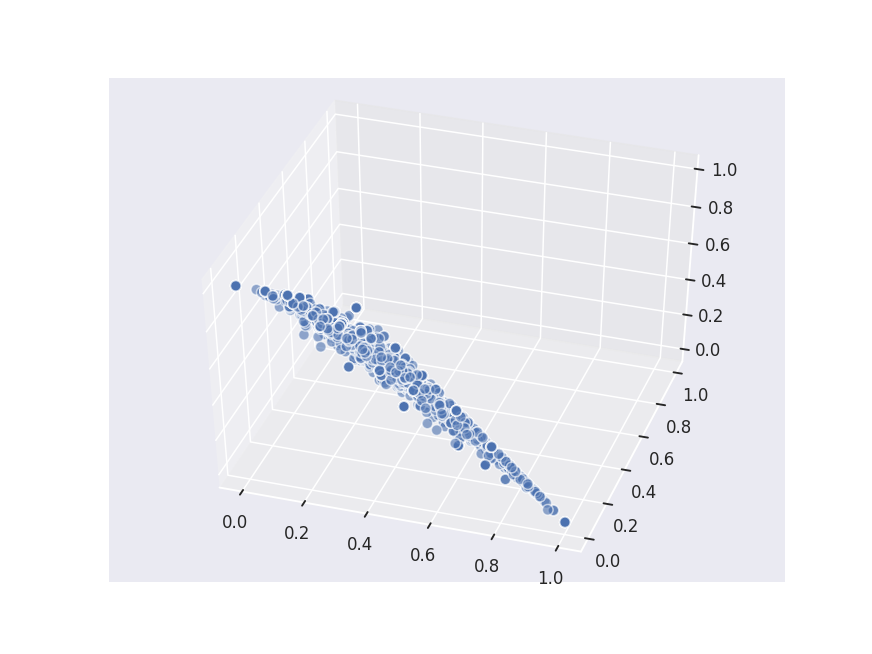

In [9]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

Test = GCV['3'].dropna()

xs = Test['11']
ys = Test['13']
zs = Test['14']
ax.scatter(xs, ys, zs, s=50, alpha=0.6, edgecolors='w')

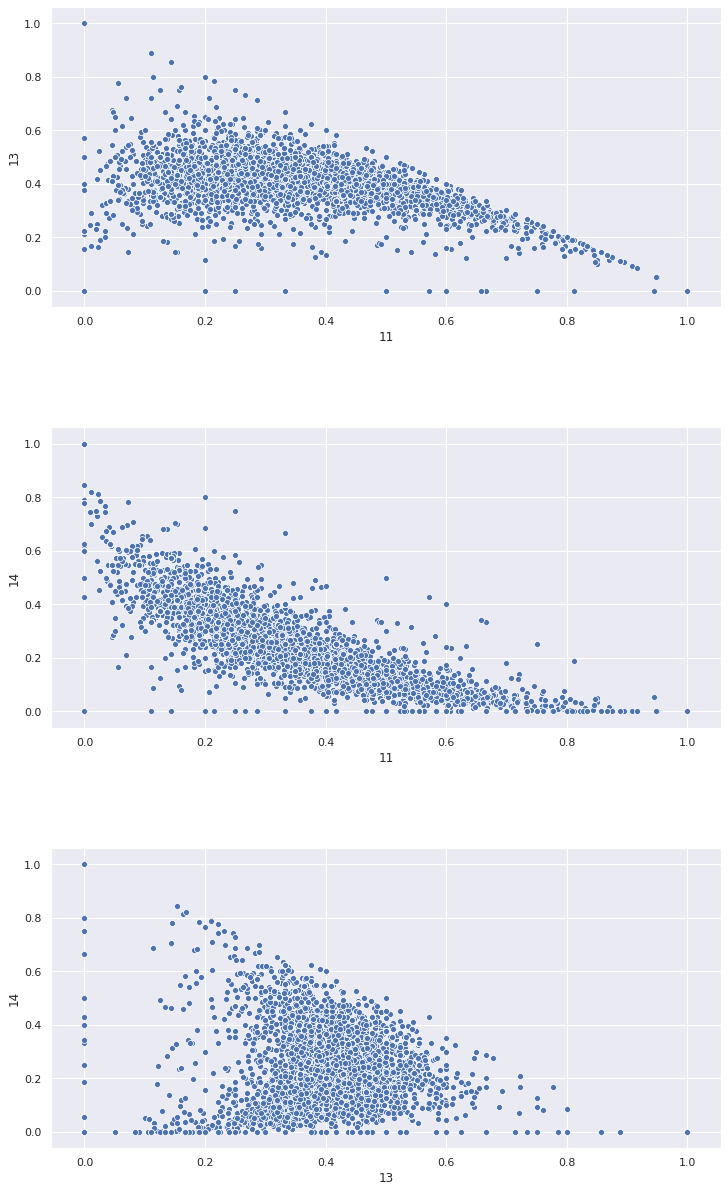

In [26]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12,21))
fig.patch.set_alpha(0)
fig.subplots_adjust(hspace = 0.4)

sns.scatterplot(data=GCV['3'], x='11', y='13', ax=ax1);
sns.scatterplot(data=GCV['3'], x='11', y='14', ax=ax2);
sns.scatterplot(data=GCV['3'], x='13', y='14', ax=ax3);

In [57]:
from random import sample

In [64]:
null, = sample(PPI_nx.nodes, 1)

In [69]:
sum(GDV['0'][gene]-1 for gene in PPI_nx[null]) == GDV['1'][null] + 2*GDV['3'][null]

True

In [71]:
sum(GDV['0'][gene]-2 for gene in PPI_nx[null]), GDV['5'][null] + GDV['10'][null] + 2*GDV['8'][null] + 2*GDV['12'][null]

(10193, 221320)

In [ ]:
sum(GDV['2'][gene] + 2*GDV['3'][gene] for gene in PPI_nx['YLR418C']), 

In [45]:
next(iter(PPI_nx['YLR418C']))

'YOL145C'

In [75]:
sum(GDV['0'][gene]-2 for gene in PPI_nx[null])

10193

In [73]:
GDV['0'].get(PPI_nx[null])

YDR190C     477
YGR240C      94
YDL160C    3589
YPL204W     184
YBR109C      92
YGR078C      13
YNL153C      25
YML094W      18
YLR200W      46
YHR172W      29
YNL126W      20
YAL047C     117
YDR356W      40
YNL188W      15
YBL032W    1117
YIL149C     248
YCR048W      30
YGR059W      55
YHL010C      52
YDL077C     843
YOR198C    1309
YKL042W      51
YGL178W    1775
Name: 0, dtype: int64